In [1]:
import kornia
import robustness
import torch as ch

In [2]:
from robustness import datasets

In [3]:
from logantools import Image

In [4]:
imn = datasets.ImageNet(data_path='/scratch/engstrom_scratch/imagenet/')

In [5]:
train_loader, _ = imn.make_loaders(1, 1024//8, data_aug=False, subset_type='first')

==> Preparing dataset imagenet..


In [6]:
_, (x,y) = next(enumerate(train_loader))

In [7]:
x = x.cuda()

In [253]:
import time
trans_constraint = 4/28.
rot_constraint = 40.

def timeit(fn, num=100):
    s = time.time()
    for _ in range(num):
        fn(x)
        
    return (time.time() - s) / num

def wrapper(transform):
    def tfm(x):
        max_trans = trans_constraint
        max_rot = rot_constraint

        bs = x.shape[0]
        rots = unif((bs,), -max_rot, max_rot)
        txs = unif((bs, 2), -max_trans, max_trans)
        
        return transform(x, rots, txs)
    
    return tfm

In [211]:
def kornia_test(x, rots, txs):
    rots = rots * 180 / 3.14159
    txs = txs * x.shape[2] / 2
    with ch.no_grad():
        rotated = kornia.rotate(x, rots)
        translated = kornia.translate(rotated, txs)
        
    return translated
    
print('Took on avg %s time over 100 iterations' % timeit(wrapper(kornia_test)))

Took on avg 0.13258631467819215 time over 100 iterations


In [266]:
_MESHGRIDS = {}

def make_meshgrid(dim=224, bs=128):
    key = (dim, bs)
    if key in _MESHGRIDS:
        return _MESHGRIDS[key]
    
    space = ch.linspace(-1, 1, 224)
    meshgrid = ch.meshgrid([space, space])
    gridder = ch.cat([meshgrid[1][..., None], meshgrid[0][..., None]], dim=2)
    grid = gridder[None, ...].repeat(128, 1, 1, 1)
    ones = ch.ones(grid.shape[:3] + (1,))
    final_grid = ch.cat([grid, ones], dim=3)
    expanded_grid = final_grid[..., None].cuda()
    
    _MESHGRIDS[key] = expanded_grid

    return expanded_grid

def unif(size, mini, maxi):
    args = {"from": mini, "to":maxi}
    return ch.cuda.FloatTensor(size=size).uniform_(**args)

def make_slice(a, b, c):
    to_cat = [a[None, ...], b[None, ...], c[None, ...]]
    return ch.cat(to_cat, dim=0)

def make_mats(rots, txs):
    # rots: degrees
    # txs: % of image dim

    rots = rots * 0.01745327778 # deg to rad
    txs = txs * 2
    
    cosses = ch.cos(rots)
    sins = ch.sin(rots)

    top_slice = make_slice(cosses, -sins, txs[:, 0])[None, ...].permute([2, 0, 1])
    bot_slice = make_slice(sins, cosses, txs[:, 1])[None, ...].permute([2, 0, 1])

    mats = ch.cat([top_slice, bot_slice], dim=1)

    mats = mats[:, None, None, :, :]
    mats = mats.repeat(1, 224, 224, 1, 1)
    return mats

def transform(x, rots, txs):
    assert x.shape[2] == x.shape[3]

    with ch.no_grad():
        meshgrid = make_meshgrid(dim=x.shape[3], bs=x.shape[0])
        tfm_mats = make_mats(rots, txs)

        new_coords = ch.matmul(tfm_mats, meshgrid)
        new_coords = new_coords.squeeze_(-1)

        new_image = ch.nn.functional.grid_sample(x, new_coords)
        return new_image

In [268]:
print('Took on avg %s time over 100 iterations' % timeit(wrapper(transform)))
# ch.matmul(cons, expanded_grid).squeeze_(-1).shape

Took on avg 0.03152015686035156 time over 100 iterations


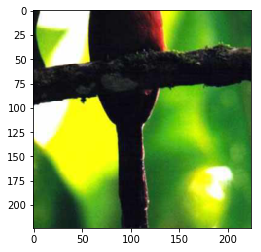

In [263]:
Image(x[0]).show()

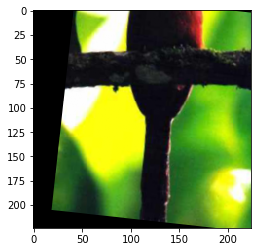

In [264]:
Image(wrapper(transform)(x)[0]).show()

In [124]:
new_image.shape

torch.Size([128, 3, 224, 224])